In [20]:
import pandas as pd
import numpy as np

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt
%matplotlib inline

In [21]:
# 读入数据
df = pd.read_csv("FE_pima-indians-diabetes-FE.csv")

# 数据分离
y = df['Target']
X = df.drop('Target', axis = 1)

In [16]:
# 稀疏数据-start
# 若数据集特征多为0,可将原始数据变为稀疏数据,可减少训练时间
# 查看一个学习期是否支持稀疏数据,可以看其fit函数是否支持:X{array-like, aparse matrix}
# 可自行使用timeit比较稠密数据和稀疏数据的训练时间
# from scipy.sparse import csr_matrix
# X_train = csr_matrix(X)
# 本数据即特征为0不算多,不使用稀疏
# 稀疏数据-end

In [22]:
# 交叉验证用于评估模型性能和进行参数调优(模型选择)
# 分类任务中交叉验证缺省是采用StratifiedKFold
# accuracy neg_log_loss
from sklearn.model_selection import cross_val_score
loss = cross_val_score(lr, X, y, cv=5, scoring='accuracy')
print('logloss of each flod is:', -loss)
print('cv logloss is:', -loss.mean())

logloss of each flod is: [-0.75974026 -0.74025974 -0.78571429 -0.79738562 -0.77124183]
cv logloss is: -0.770868347339


In [58]:
# Logistic Regression + GridSearchCV
# logistic回归的需要调整超参数有:C(正则系数,一般在log域(取log后的值), 均匀设置候选参数)和正则函数penalty(L2/L1)
# 目标函数为J = C*sum(logloss(f(xi), yi)) + penalty
#　在sklearn框架下，不同学习期的参数调整步骤相同：
# 1. 设置参数搜索范围
# 2. 生成学习器示例（参数设置）
# 3. 生成GridSearchCV的示例(参数设置)
# 4. 调用GrdSearchCV的fit方法

X_train = X.values
y_train = y.values
lr = LogisticRegression()
penaltys = ['l1', 'l2']
Cs = [0.01, 0.1, 1, 10, 100]
tuned_parammeters = dict(penalty=penaltys, C = Cs)

lr_penalty = LogisticRegression(solver='liblinear')

#scorings = ['accuracy','neg_log_loss']


grid = GridSearchCV(lr_penalty, tuned_parammeters, cv=5, scoring='accuracy', return_train_score = True)
grid.fit(X_train, y_train)

print('accuracy', ' score:', abs(grid.best_score_))
print('accuracy', ' params:', grid.best_params_)


accuracy  score: 0.774739583333
accuracy  params: {'C': 0.1, 'penalty': 'l2'}


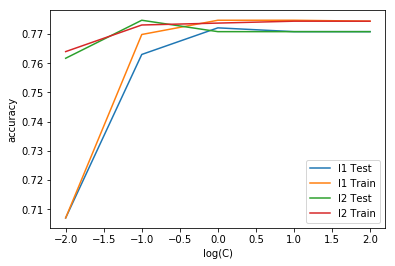

In [62]:
test_means = grid.cv_results_['mean_test_score']
test_stds = grid.cv_results_['std_test_score']
train_means = grid.cv_results_['mean_train_score']
train_stds = grid.cv_results_['std_train_score']

n_Cs = len(Cs)
number_penaltys = len(penaltys)
test_scores  = np.array(test_means).reshape(n_Cs, number_penaltys)
train_scores   = np.array(train_means).reshape(n_Cs, number_penaltys)
test_stds = np.array(test_stds).reshape(n_Cs, number_penaltys)
train_stds  = np.array(train_stds).reshape(n_Cs, number_penaltys)

x_axis = np.log10(Cs)
for i, value in enumerate(penaltys):
    #plt.errorbar(x_axis, test_scores[:,i], yerr=test_stds[:,i], label = penaltys[i]+' Test')
    #plt.errorbar(x_axis, train_scores[:,i], yerr=train_stds[:,i], label = penaltys[i]+' Train')
    plt.errorbar(x_axis, test_scores[:,i], label = penaltys[i]+' Test')
    plt.errorbar(x_axis, train_scores[:,i], label = penaltys[i]+' Train')

plt.legend()
plt.xlabel('log(C)')
plt.ylabel('accuracy')
plt.savefig('logisticGridSearchCV_accuracy_C.png')

plt.show()

In [ ]:
上图给出了L1正则和L2正常在正则参数C对象的模型,在训练集上的 accuracy.
可以看出在训练集上使用l2正则,正则参数C在0.1处(log(C)=-1)达到函数达到最大值,此时模型最好

In [55]:
grid = GridSearchCV(lr_penalty, tuned_parammeters, cv=5, scoring='neg_log_loss', return_train_score = True)
grid.fit(X_train, y_train)

print('neg_log_loss', ' score:', abs(grid.best_score_))
print('neg_log_loss', ' params:', grid.best_params_)

neg_log_loss  score: 0.476026635474
neg_log_loss  params: {'C': 1, 'penalty': 'l1'}


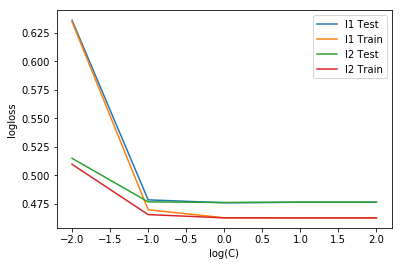

In [56]:
test_means = grid.cv_results_['mean_test_score']
test_stds = grid.cv_results_['std_test_score']
train_means = grid.cv_results_['mean_train_score']
train_stds = grid.cv_results_['std_train_score']

n_Cs = len(Cs)
number_penaltys = len(penaltys)
test_scores  = np.array(test_means).reshape(n_Cs, number_penaltys)
train_scores   = np.array(train_means).reshape(n_Cs, number_penaltys)
test_stds = np.array(test_stds).reshape(n_Cs, number_penaltys)
train_stds  = np.array(train_stds).reshape(n_Cs, number_penaltys)

x_axis = np.log10(Cs)
for i, value in enumerate(penaltys):
    #plt.errorbar(x_axis, test_scores[:,i], yerr=test_stds[:,i], label = penaltys[i]+' Test')
    #plt.errorbar(x_axis, train_scores[:,i], yerr=train_stds[:,i], label = penaltys[i]+' Train')
    plt.errorbar(x_axis, -test_scores[:,i], label = penaltys[i]+' Test')
    plt.errorbar(x_axis, -train_scores[:,i], label = penaltys[i]+' Train')

plt.legend()
plt.xlabel('log(C)')
plt.ylabel('logloss')
plt.savefig('logisticGridSearchCV_C.png')

plt.show()

上图给出了L1正则和L2正常在正则参数C对象的模型,在训练集上的neglogloss.
可以看出在训练集上C越大越好(正则越小越好),正则参数C在1处(log(C)=0)达到函数达到收敛,此时模型最好
当C=1处,各训练集上的得分相差不大

In [57]:
#import cPickle

#cPickle.dump(grid.best_estimator_, open('l1_org.pkl', 'wb'))

ModuleNotFoundError: No module named 'cPickle'